In [146]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import time
from collections import Counter
from scipy.optimize import root
import heapq


In [147]:
layout = pd.read_json("clean_network.json", orient="index")

In [148]:
layout.loc["Jonctiune-1414"]

x                           730678.855
y                           421170.761
connections    [207-A, Jonctiune-2186]
Name: Jonctiune-1414, dtype: object

In [149]:
def make_connections(layout):
    connections_array = []
    names_array = []
    for idx, connection in enumerate(layout["connections"]):
        x1, y1 = layout.iloc[idx].x, layout.iloc[idx].y
        for junction in connection:
            if [layout.iloc[idx].name, layout.loc[junction].name] not in names_array and [layout.loc[junction].name, layout.iloc[idx].name] not in names_array:
                x2, y2 = layout.loc[junction].x, layout.loc[junction].y
                connections_array.append([x1, x2, y1, y2])
                names_array.append([layout.iloc[idx].name, layout.loc[junction].name])
    return connections_array, names_array

In [150]:
connections_array, names_array = make_connections(layout)

In [151]:
def prepare_dijkstra_conn(layout):
    connections_dict = {}
    for index, junction in layout.iterrows():
        
        name = junction.name
        connections_dict[name] = {}
        for conn in junction.connections:
            x2, y2 = layout.loc[conn].x, layout.loc[conn].y
            distance = np.sqrt(((junction.x-x2)*11.32)**2 + ((junction.y-y2)*11.32)**2)
            connections_dict[name][conn] = distance
            
    return connections_dict
            

In [152]:
dijkstra_graph = prepare_dijkstra_conn(layout)
#np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning) 
np.warnings.filterwarnings('ignore')

In [153]:
def strength_function(x1, x2, y1, y2, current_strength, k):
    distance = np.sqrt(((x2-x1)*11.32)**2 + ((y2-y1)*11.32)**2)
    #distance = distance_deg * 11.32 ## approximate distance in m
    strength = current_strength - distance**0.02
    return strength

In [154]:
def set_point_of_leakage(connections, names):
    n_pipe = random.randint(0, len(connections)-1)
    leakage_pipe = connections[n_pipe]
    leakage_depth = random.random()
    x1, x2, y1, y2 = leakage_pipe
    neigh_a, neigh_b = names[n_pipe]
    x_of_leakage = x1*(1-leakage_depth) + x2*leakage_depth
    y_of_leakage = y1*(1-leakage_depth) + y2*leakage_depth
    return [x_of_leakage, y_of_leakage], [neigh_a, neigh_b]

In [155]:
def set_primary_signal(point_of_leakage, neighbour_junctions, leakage_strength):
    strength_map = {}
    x1, y1 = point_of_leakage
    for junction in neighbour_junctions:
        x2, y2 = layout.loc[junction].x, layout.loc[junction].y
        strength_map[junction] = [x2, y2, strength_function(x1, x2, y1, y2, leakage_strength, 1)]
    return strength_map

In [156]:
def loudness_function(x1, x2, y1, y2, current_strength):
    distance = np.sqrt(((x2-x1)*11.32)**2 + ((y2-y1)*11.32)**2)
    #distance = distance_deg * 11.32 ## approximate distance in m
    strength = current_strength -distance**0.02
    return strength

In [157]:
def set_test_signal(strength_map, layout):
    primary_junction_a, primary_junction_b = strength_map.keys()
    already_set = [[primary_junction_a, [point_of_leakage,
                                        layout.loc[primary_junction_a].connections]],
                   [primary_junction_b, [point_of_leakage,
                                        layout.loc[primary_junction_b].connections]]]
    for junction in already_set:
        #if junction[0] == primary_junction_a or junction[0] == primary_junction_b:
        x1, y1 = strength_map[junction[0]][0], strength_map[junction[0]][1]
        for connection in junction[1][1]:
            if connection not in [x[0] for x in already_set]:
                x2, y2 = layout.loc[connection].x, layout.loc[connection].y
                n_connections = len(junction[1][1]) -1 
                starting_strength = strength_map[junction[0]][-1] ## takes strength of previous junction from strength map
                strength = loudness_function(x1, x2, y1, y2, starting_strength)# + 10*np.log10(1/n_connections)
                if strength < 0: #minimum sensitivity
                    strength = 0
                strength_map[connection] = [x2, y2, strength]
                already_set.append([connection, [junction[0], 
                                              layout.loc[connection].connections]])

In [158]:
def calculate_distances(graph, starting_vertex):
    distances = {vertex: float('infinity') for vertex in graph}
    joints = {vertex: 0 for vertex in graph}
    distances[starting_vertex] = 0
    joints[starting_vertex] = 0
    pq = [(0, starting_vertex, 0)]
    while len(pq) > 0:
        current_distance, current_vertex, current_joint = heapq.heappop(pq)
        #print("CURRENT ", current_vertex)
        # Nodes can get added to the priority queue multiple times. We only
        # process a vertex the first time we remove it from the priority queue.
        if current_distance > distances[current_vertex]:
            continue
        for neighbor, weight in graph[current_vertex].items():
            distance = current_distance + weight
            n_joints = current_joint + 1
            # Only consider this new path if it's better than any path we've
            # already found.
            if distance < distances[neighbor]:
                distances[neighbor] = distance
                joints[neighbor] = n_joints
                heapq.heappush(pq, (distance, neighbor, n_joints))
                
    distances = {key:val for key, val in distances.items() if val != np.inf}
    return distances, joints

In [159]:
def get_trail(graph, starting_vertex):
    distances = {vertex: float('infinity') for vertex in graph}
    trail = {vertex: [starting_vertex] for vertex in graph}
    distances[starting_vertex] = 0
    trail[starting_vertex] = [starting_vertex, 0]
    pq = [(0, starting_vertex, [[starting_vertex, 0]])]
    while len(pq) > 0:
        current_distance, current_vertex, temp = heapq.heappop(pq)
        #print("CURRENT ", current_vertex)
        # Nodes can get added to the priority queue multiple times. We only
        # process a vertex the first time we remove it from the priority queue.
        if current_distance > distances[current_vertex]:
            continue
        for neighbor, weight in graph[current_vertex].items():
            distance = current_distance + weight
            tempo = np.append(temp, [[neighbor, weight]], axis=0)
            # Only consider this new path if it's better than any path we've
            # already found.
            if distance < distances[neighbor]:
                distances[neighbor] = distance
                trail[neighbor] = tempo
                heapq.heappush(pq, (distance, neighbor, tempo))
                
    distances = {key:val for key, val in distances.items() if val != np.inf}
    return trail

In [160]:
dijkstra_map, n_joints = calculate_distances(dijkstra_graph, "SenzorComunarzi-NatVech")

In [161]:
trail = get_trail(dijkstra_graph, "SenzorComunarzi-NatVech")

import time

start = time.time()
for i in range(1000):
    total_junction_fall = np.sum([-10*0.342*np.log10(1/(len(layout.loc[x].connections)-1)) for x in trail["Jonctiune-J-25"][:-1, 0]])
end = time.time()
print(end - start)
start = time.time()
for i in range(1000):
    tot_splits = np.product([len(layout.loc[x].connections)-1 for x in trail["Jonctiune-J-25"][:-1, 0]])
    total_junction_fall_new = -10*0.342*np.log10(1/tot_splits)
end = time.time()
print(end - start)



In [162]:
faulty = []

In [163]:
def new_strength_map(leakage_strength, layout, connections, names):
    point_of_leakage, neigh = set_point_of_leakage(connections, names)
    strength_map = set_primary_signal(point_of_leakage, neigh, leakage_strength)
    
    for start_junction in neigh:
        start_strength = strength_map[start_junction][-1]
        trail = get_trail(dijkstra_graph, start_junction)
        for endpoint in trail:
            if endpoint == start_junction: continue
            try: ## this is to catch currently isolated junctions
                    #print("EDNOINOAN", endpoint)
                    #print(trail[endpoint])
                total_strength_fall = np.sum([float(x)**0.02 for x in trail[endpoint][:, -1]])
                ## total_junction_fall is fall in strength due to pipe division in junction 
                ## calculated with 10*log10(1/split) 
                total_junction_fall = sum([-10*np.log10(1/(len(layout.loc[x].connections)-1)) for x in trail[endpoint][:-1, 0] if len(layout.loc[x].connections)-1 != 0])
                #total_junction_fall = -10*np.log10(1/total_splits)
                total_strength = start_strength - total_strength_fall - total_junction_fall
                if total_strength < 0: total_strength = 0
                if endpoint in strength_map.keys() and total_strength > strength_map[endpoint][-1]:
                    x, y = layout.loc[endpoint].x, layout.loc[endpoint].y
                    strength_map[endpoint] = [x, y, total_strength]
                elif endpoint not in strength_map.keys():
                    x, y = layout.loc[endpoint].x, layout.loc[endpoint].y
                    strength_map[endpoint] = [x, y, total_strength]
            except TypeError as e:
                if endpoint not in faulty:
                    faulty.append(endpoint)
                    print(endpoint, trail[endpoint])
    return strength_map, point_of_leakage

In [164]:
#test_map = new_strength_map(100, layout, connections_array, names_array)

[731031.1334253262, 420737.6784399459]


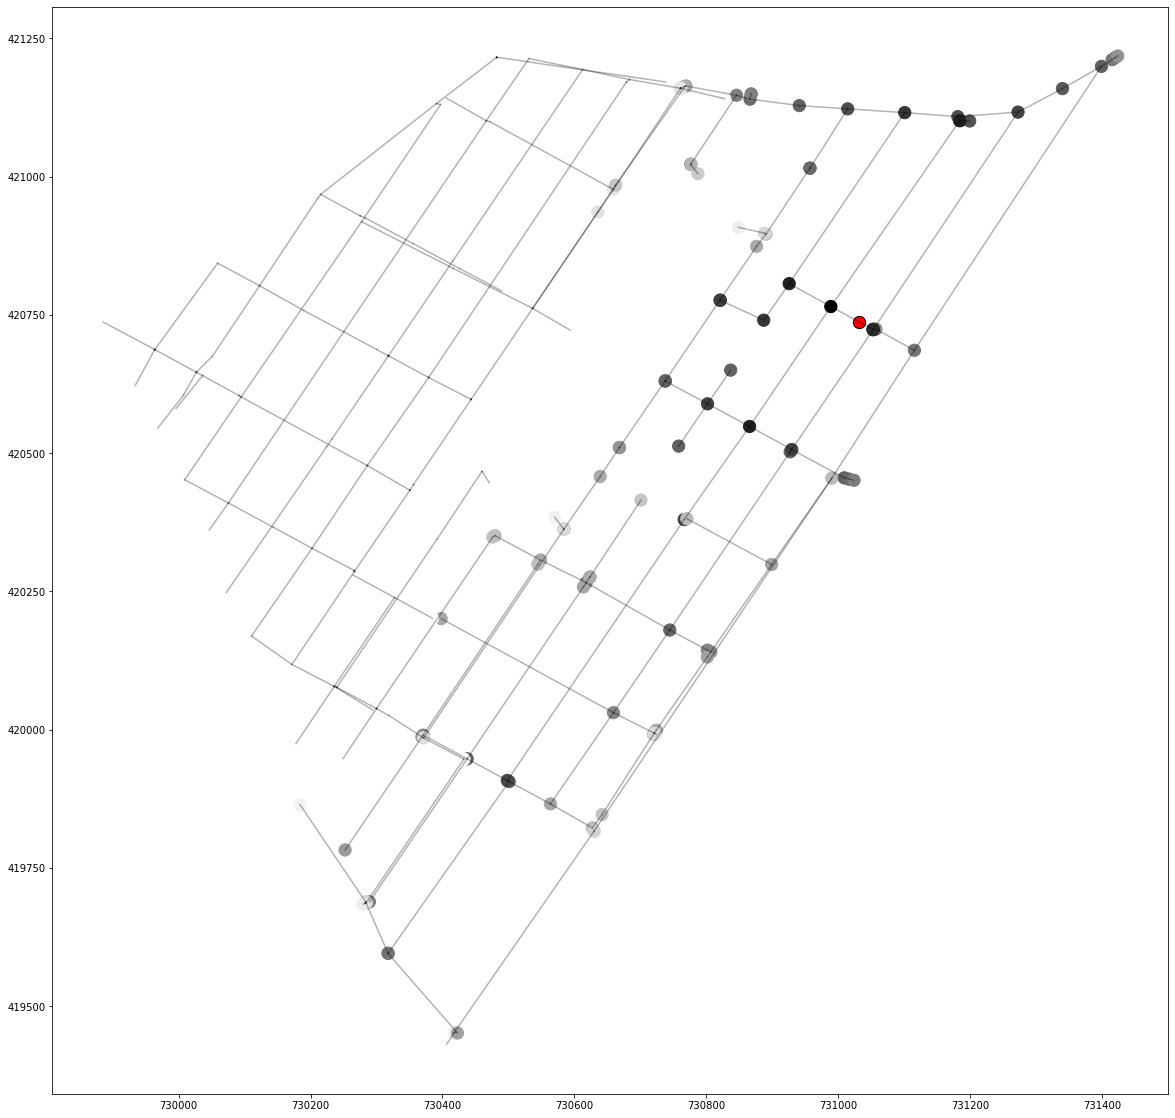

In [353]:
strength_map, point_of_leakage = new_strength_map(48, layout, connections_array, names_array)
strength_map = pd.DataFrame(strength_map.values(), index=strength_map.keys(),columns=["x", "y", "strength"])
plt.figure(figsize=(20, 20))
plt.scatter(strength_map.x, strength_map.y, c=strength_map.strength, s=150, cmap="gray_r")
for connection in connections_array:
    plt.plot(connection[:2], connection[2:4], "k-", alpha=0.3)
plt.scatter(point_of_leakage[0], point_of_leakage[1], s=150, c="red", edgecolors="k")
print(point_of_leakage)

In [354]:
strength_map.sort_values("strength", ascending=False)

,x,y,strength
261-A,731053.010,420723.563,46.879561
Jonctiune-2203,730988.974,420764.881,46.864763
Jonctiune-2201,731053.351,420723.353,42.838570
Jonctiune-2204,730925.785,420806.340,40.948975
Jonctiune-J-16,730865.740,420548.080,40.921317
...,...,...,...
Jonctiune-3921,729963.078,420687.558,0.000000
Jonctiune-3912,730265.362,420288.161,0.000000
Jonctiune-3566,730275.074,420928.980,0.000000
Jonctiune-3510,730250.664,420720.124,0.000000


In [355]:
sensors = np.array([strength_map.loc[sensor].values for sensor in strength_map.index if "Senzor" in sensor])

In [356]:
strength_map.loc[init_param["starting_sensors"]]

,x,y,strength
SenzorComunarzi-castanului,730171.623,420117.800,0.000000
SenzorComunarzi-NatVech,730761.029,421159.518,10.871276
SenzorChisinau-Titulescu,730744.713,420180.045,27.969799
SenzorCernauti-Sebesului,730318.013,420675.896,0.000000
Jonctiune-2879,730110.326,420169.011,0.000000
Jonctiune-2879,730110.326,420169.011,0.000000
Jonctiune-2879,730110.326,420169.011,0.000000


In [357]:
sensor = "SenzorComunarzi-NatVech"

In [358]:
def create_signal_mesh(sensor):
    signal_mesh = {}
    sensor_signal_mesh = get_trail(dijkstra_graph, sensor)
    sensor_strength = strength_map.loc[sensor][-1]
    for node in sensor_signal_mesh:
        if node == sensor:
            signal_mesh[sensor] = sensor_strength
            continue
        total_strength_fall = np.sum([float(x)**init_param["fall_exp"] for x in sensor_signal_mesh[node][:, -1]])
        total_junction_fall = sum([-10*np.log10(1/(len(layout.loc[x].connections)-1)) for x in sensor_signal_mesh[node][1:, 0] if len(layout.loc[x].connections)-1 != 0])
        node_strength = sensor_strength + total_junction_fall + total_strength_fall
        signal_mesh[node] = node_strength
    return signal_mesh    

In [359]:
def get_source_strength():
    total_signal_mesh = {}
    n_sensors = 0
    for sensor in init_param["starting_sensors"][-4:]:
        if strength_map.loc[sensor][-1] == 0: continue
        signal_mesh = create_signal_mesh(sensor)
        for node in signal_mesh:
            if node not in total_signal_mesh.keys():
                total_signal_mesh[node] = signal_mesh[node]
            else:
                total_signal_mesh[node] += signal_mesh[node]
        n_sensors += 1
    #print("Predicting a source signal of ", np.max(list(total_signal_mesh.values()))/n_sensors)
    print("Predicting a source signal of ", np.mean(list(total_signal_mesh.values()))/(n_sensors))
    print("Predicting a source signal of ", np.median(list(total_signal_mesh.values()))/(n_sensors))
    mean =  np.mean(list(total_signal_mesh.values()))/(n_sensors)
    median =  np.median(list(total_signal_mesh.values()))/n_sensors
    minimum = np.min(list(total_signal_mesh.values()))/n_sensors 
    maximum = np.max(list(total_signal_mesh.values()))/n_sensors
    max_err = maximum - median
    min_err = median - minimum
    correct = median - (max_err+min_err)/2
    print("Corrected ", correct)
    
    #print("Predicting a source signal of ", np.min(list(total_signal_mesh.values()))/n_sensors)
    #print("Predicting a source signal of ", np.median(list(total_signal_mesh.values()))*np.sqrt(init_param["fall_exp"]))
    #init_param["source_strength"] = correct
    return correct ### maybe add new sensors in future!!

In [360]:
init_param = {
    "source_strength": 25,
    "fall_exp": 0.02,
    "junction_division": "equal",
    "tolerance": 1,
    "upper_limit": 65,
    "starting_sensors" : ["SenzorComunarzi-castanului", "SenzorComunarzi-NatVech", "SenzorChisinau-Titulescu", "SenzorCernauti-Sebesului"],
    "avg_division":1
}

In [361]:
def distance_approximator(strength, strength_fall, name_of_sensor, dijkstra_map, n_junctions, error_tolerance):
    approx_start = time.time()
    possible_leak_neigh = []
    check_trail = get_trail(dijkstra_graph, name_of_sensor)
    while len(possible_leak_neigh) == 0: 
        for junction, distance in dijkstra_map.items():
            if distance != 0:
                hypothetical_fall = sum([float(x)**init_param["fall_exp"] for x in check_trail[junction][:, -1]])
                    
                #if hypothetical_fall <= strength_fall:
                total_splits = np.product([len(layout.loc[x].connections)-1 for x in check_trail[junction][1:, 0] if len(layout.loc[x].connections) != 1]) 
                total_junction_fall = -10*np.log10(1/total_splits)
                error = strength_fall - hypothetical_fall -total_junction_fall # comparing actual fall in strength with fall due to distance and pipe division
                #if error_tolerance > 10: 
                    #print(error)
                if abs(error) < error_tolerance:
                    possible_leak_neigh.append(junction)
        error_tolerance += 1
        print(error_tolerance)
    approx_stop = time.time()
    print("Approximation time: ", approx_stop-approx_start)
    return possible_leak_neigh

In [362]:
layout.loc["Jonctiune-1406"][["connections", "x", "y"]]

connections    [Jonctiune-1405, 253-A, 202-A, 203-A]
x                                         729964.076
y                                         420686.917
Name: Jonctiune-1406, dtype: object

In [363]:
def get_out(check_junction):
    x1, y1 = layout.loc[check_junction][["x", "y"]]
    for conn in layout.loc[check_junction].connections:
        x2, y2 = layout.loc[conn][["x", "y"]]
        dist = np.sqrt(((x2-x1)*11.32)**2 + ((y2-y1)*11.32)**2)
        predicted_fall = dist ** init_param["fall_exp"]
        actual_fall = abs(init_param["source_strength"] - strength_map.loc[conn][-1])
        if predicted_fall > actual_fall:
            return True
        
    return False

In [364]:
def faulty_pipe(names_array):
    current_best = [0, None, None]
    for sensor1 in init_param["starting_sensors"]:
        for sensor2 in init_param["starting_sensors"]:
            strength_sum = 0
            if [sensor1, sensor2] in names_array or [sensor2, sensor1] in names_array:
                strength_sum = strength_map.loc[sensor1].strength + strength_map.loc[sensor2].strength
                print(f"Possible faulty pipe found! \n################################################################")
            if strength_sum > current_best[0]:
                print("Current probable faulty pipe with nodes: ",sensor1, sensor2)
                current_best = [strength_sum, sensor1, sensor2]
    print(current_best)
    return current_best[1], current_best[2]

In [365]:
def find_pipe(node):
    current_best = [node, 0]
    for conn in layout.loc[node].connections:
        strength = strength_map.loc[conn].strength
        if strength > current_best[1]:
            current_best = [conn, strength]
    print(f"LEAKAGE FOUND BETWEEN {node} and {current_best[0]}")
    raise SystemExit(f"LEAKAGE FOUND BETWEEN {node} and {current_best[0]}")
    loop = False
    
    return 

In [366]:
def save_exp(PATH, exp):
    with open(PATH, "a") as logger:
        logger.write(f"{exp}\n")
        print("Saved exp!")
    return 

In [367]:
def calibrate(sensors, possible_junctions, randomize):
    calib_start = time.time()
    if randomize:
        idx = random.randint(0, len(list(layout.index))-1)
        check_junction = list(layout.index)[idx]
    else: 
        check_junction = possible_junctions[0]
    total_dist_err = 0
    total_junctions = 0
    total_strength = 0
    change_exp = []
    ## check for correct
    #stop_loop = get_out(check_junction)
    #if stop_loop:
    #    find_pipe(check_junction)
  
    if check_junction in init_param["starting_sensors"]: 
            print("appending same againn")
            #find_pipe(check_junction)
            #raise SystemExit("Leakage found at ", check_junction) ### IN THE FUTURE, CHANGE RAISE TO stop = True to break out of loop
    for sensor in init_param["starting_sensors"]:
        if strength_map.loc[sensor].strength == 0: continue ##checks whether a sensor is getting any signal at all
        dijkstra_map, n_joints = calculate_distances(dijkstra_graph, sensor)
        trail = get_trail(dijkstra_graph, sensor)
        actual_strength = strength_map.loc[check_junction].strength ### strength of newly checked sensor
        sensor_strength = strength_map.loc[sensor].strength ### strength of starting sensor
        ## calculating fall due to pipe splits
        try:
            total_splits = np.product([len(layout.loc[x].connections)-1 for x in trail[check_junction][1:, 0] if len(layout.loc[x].connections) != 1])
        except:
            find_pipe(check_junction)
        total_junction_fall = -10*np.log10(1/total_splits)
        predicted_strength = sensor_strength + sum([float(x)**init_param["fall_exp"] for x in trail[check_junction][:, -1]]) + total_junction_fall
        print("PREDICTED", predicted_strength)
        print("ACTUAL: ", actual_strength)
        total_dist_err += predicted_strength - actual_strength
    ###################################### DISTANCE LOSS CORRECTION ##############################################
        true_fall = abs(actual_strength - sensor_strength)
        new_exp = 0
        print(true_fall, total_junction_fall)
        def exp_fall_eq(x):
            func = sum([float(el)**x for el in trail[check_junction][:, -1]])
            func = func - true_fall + total_junction_fall
            return func
        new_exp_solve = root(exp_fall_eq, 1, tol=1e-10)
        print("Solved", new_exp_solve.success)
        
        new_exp = new_exp_solve.x
        if not new_exp_solve.success:
            new_exp = init_param["fall_exp"]
        
        change_exp.append(new_exp * sensor_strength)
        total_strength += sensor_strength
    param_exp_change = np.sum(change_exp)/total_strength
    print("CHANGE FALL EXP TO ", param_exp_change)
    save_exp("./exp_log.txt", str(param_exp_change))
    calib_stop = time.time()
    print("Calibration time: ", calib_stop-calib_start)
    return param_exp_change
   

In [368]:
def locate(sensors):
    locate_start = time.time()
    print("USING: ", init_param)
    source_strength = init_param["source_strength"]
    predicted_source_strength = 0
    high_potential = []
    ignore_sensor = 0
    while len(high_potential) == 0:
        plural_predictions = []
        n_sensors_used = 0 - ignore_sensor
        for sensor in init_param["starting_sensors"]:
            sensor_strength = strength_map.loc[sensor][-1]
            if sensor_strength == 0: continue
            n_sensors_used += 1
            strength_fall = abs(source_strength - sensor_strength)
            print(sensor_strength)
            dijkstra_map, n_junctions = calculate_distances(dijkstra_graph, sensor)
            singular_predictions = distance_approximator(sensor_strength, strength_fall, sensor, dijkstra_map, n_junctions, init_param["tolerance"])
            for possible in singular_predictions:
                plural_predictions.append(possible)
        #print(plural_predictions)
        high_potential = [item for item, count in Counter(plural_predictions).items() if count > n_sensors_used-1]
        source_strength += .5
        print("updating source strength to ", source_strength, "///////////////////////////////////////////////////////////////////////////////////////////\n")
        
        if source_strength >= init_param["upper_limit"]:
            source_strength = init_param["source_strength"]
            ignore_sensor += 1
    locate_stop = time.time()
    init_param["source_strength"] = source_strength
    print("Location search time: ", locate_stop-locate_start)
    return high_potential
    

In [369]:
def keep_track(arr):
    temp_log = arr.flatten()
    high_proba = [item for item, count in Counter(temp_log).items() if count > 5]
    if high_proba != []:
        print("FOund JUN ", high_proba)
        loop = False

USING:  {'source_strength': 25, 'fall_exp': 0.02, 'junction_division': 'equal', 'tolerance': 1, 'upper_limit': 65, 'starting_sensors': ['SenzorComunarzi-castanului', 'SenzorComunarzi-NatVech', 'SenzorChisinau-Titulescu', 'SenzorCernauti-Sebesului'], 'avg_division': 1}
10.871276385481796
2
Approximation time:  0.7169992923736572
27.9697994234076
2
3
Approximation time:  1.2640001773834229
updating source strength to  25.5 ///////////////////////////////////////////////////////////////////////////////////////////

10.871276385481796
2
3
Approximation time:  1.4019951820373535
27.9697994234076
2
3
Approximation time:  1.2470026016235352
updating source strength to  26.0 ///////////////////////////////////////////////////////////////////////////////////////////

10.871276385481796
2
3
Approximation time:  1.412001609802246
27.9697994234076
2
Approximation time:  0.6269974708557129
updating source strength to  26.5 ////////////////////////////////////////////////////////////////////////////

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



appending same againn
PREDICTED 49.90783101478959
ACTUAL:  46.86476324233417
35.99348685685237 25.84331224367531
Solved True
PREDICTED 48.43540037217443
ACTUAL:  46.86476324233417
18.89496381892657 14.313637641589875
Solved True
LEAKAGE FOUND BETWEEN Jonctiune-2203 and 261-A
Traceback (most recent call last):
  File "<ipython-input-367-80e346f7ccfe>", line 29, in calibrate
    total_splits = np.product([len(layout.loc[x].connections)-1 for x in trail[check_junction][1:, 0] if len(layout.loc[x].connections) != 1])
TypeError: list indices must be integers or slices, not tuple

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Jaka\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-370-33016b286a53>", line 15, in <module>
    new_fall_exp = calibrate(sensors, agreed, randomize=False)
  File "<ipython-input-36

TypeError: object of type 'NoneType' has no len()

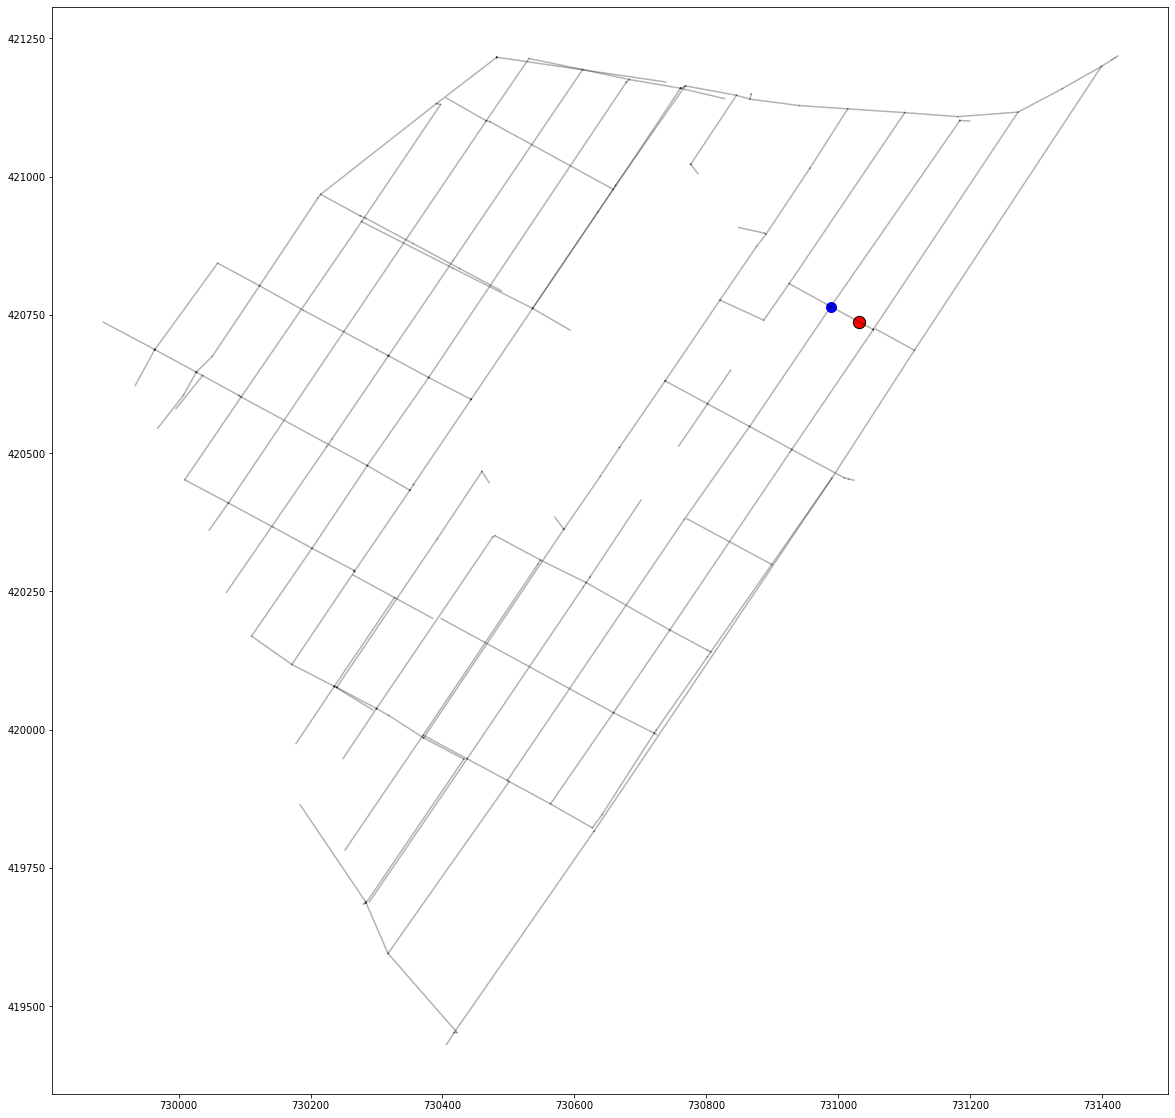

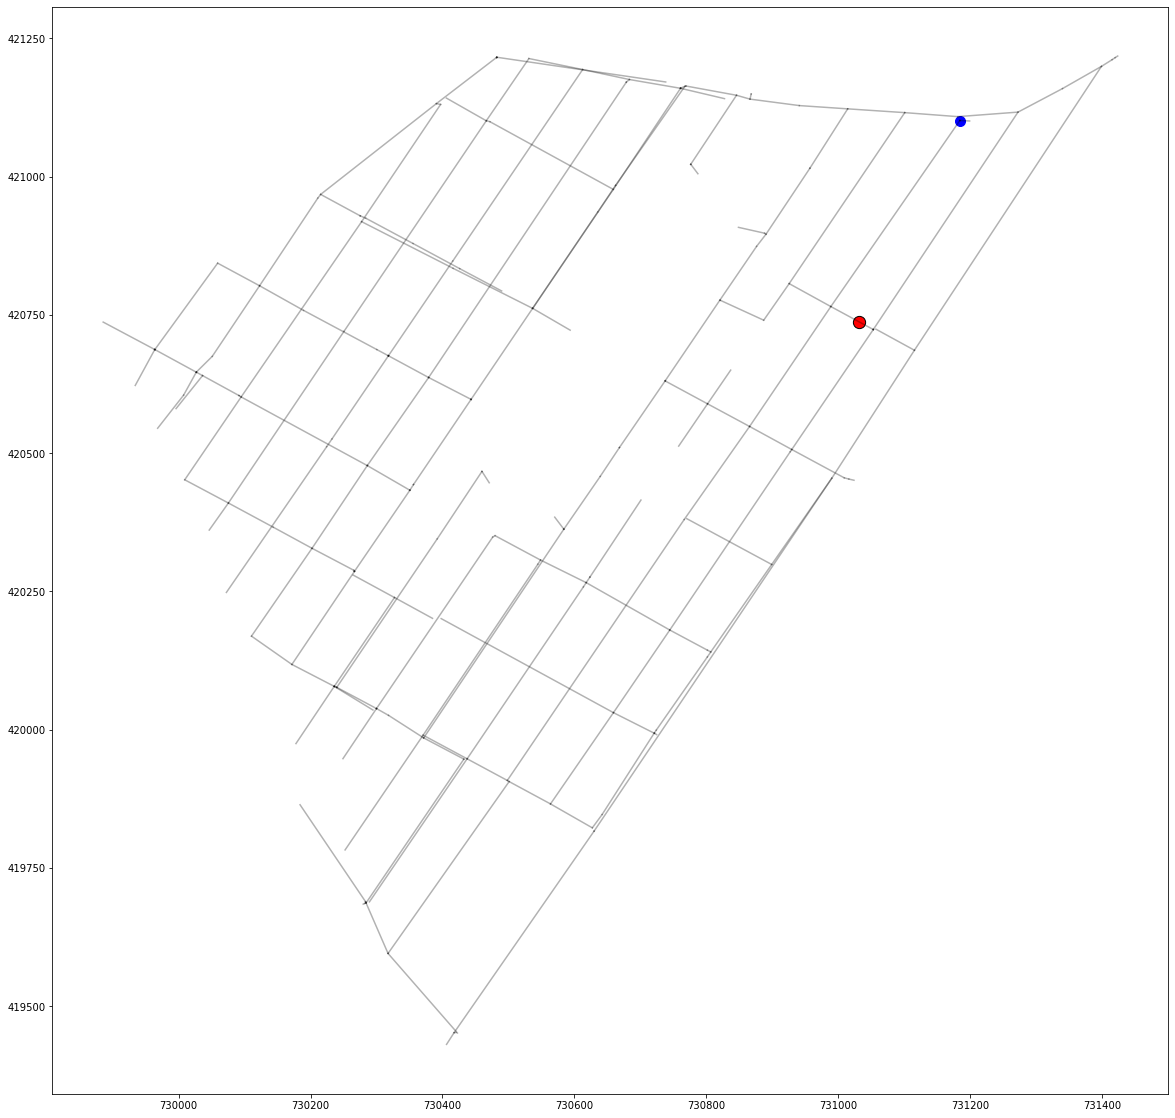

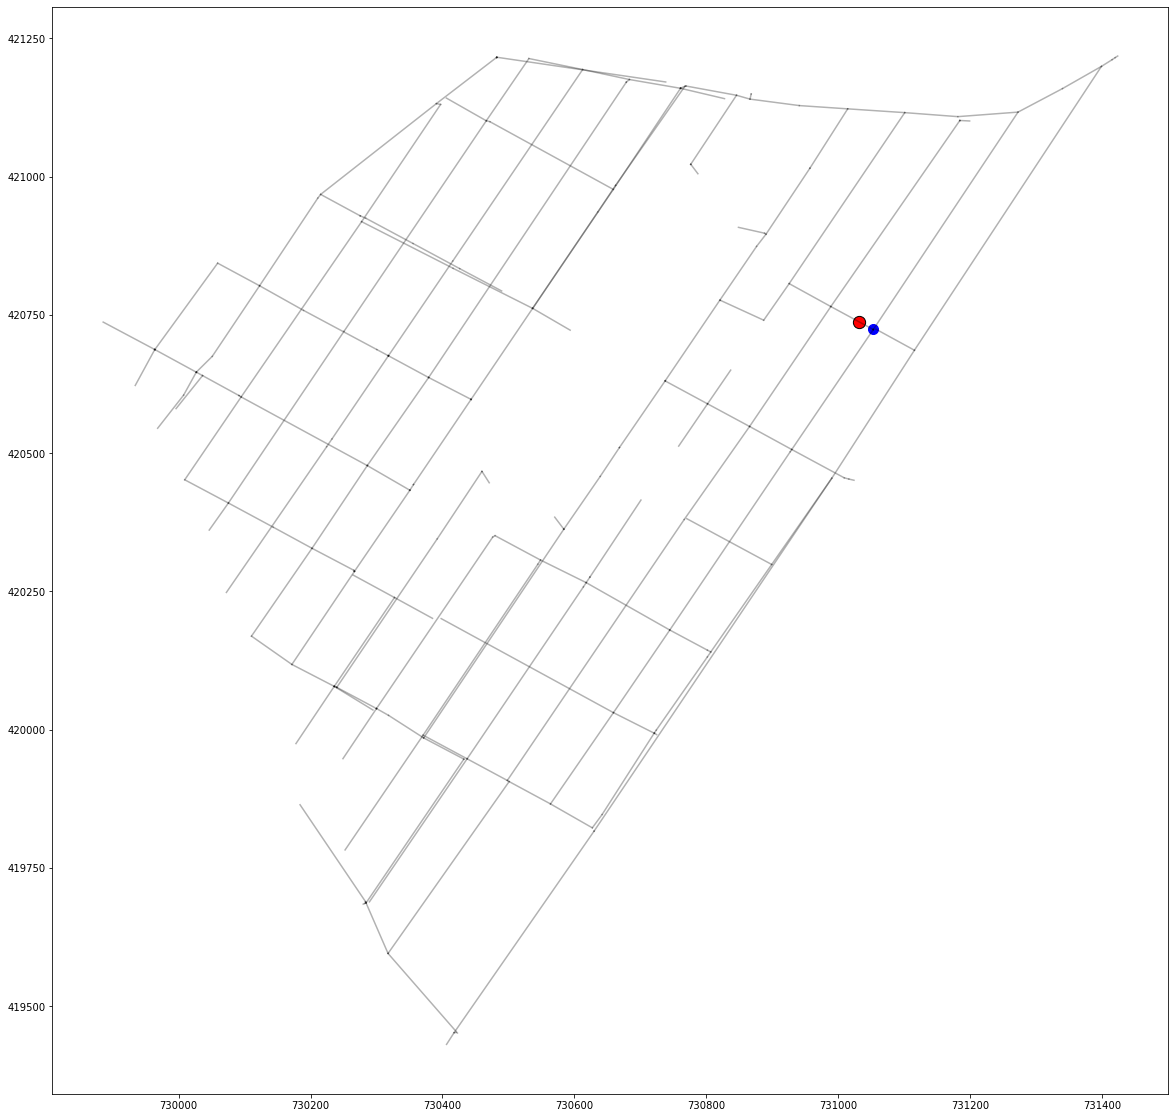

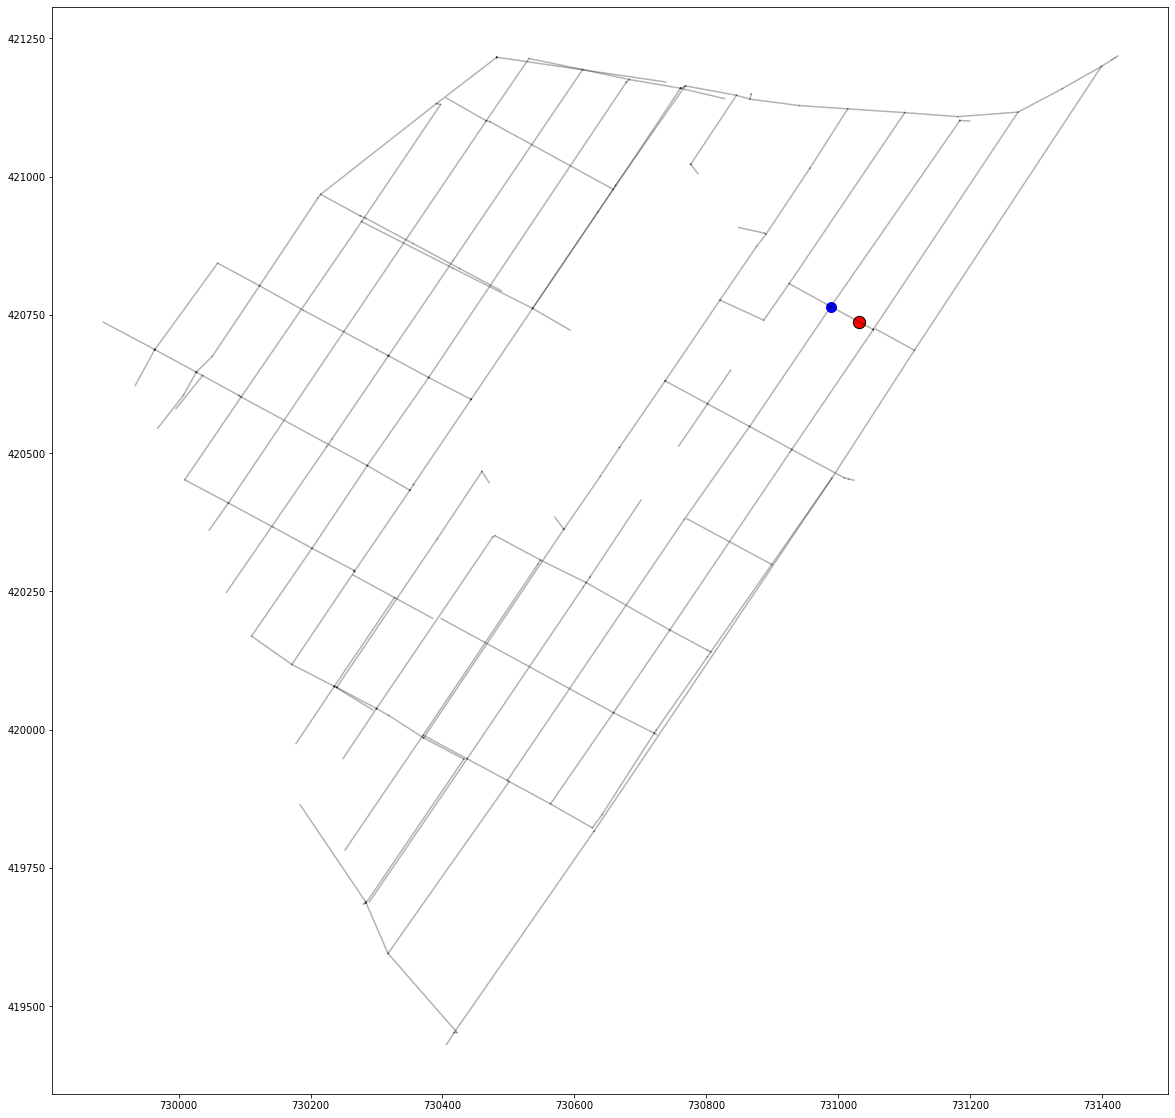

In [370]:
loop = True
prev_source_strength = 0
freq_predicted = np.array([])
while loop == True:
    agreed = locate(sensors)
    plt.figure(figsize=(20, 20))
    np.append(freq_predicted, np.array(agreed))
    keep_track(freq_predicted)
    for connection in connections_array:
        plt.plot(connection[:2], connection[2:4], "k-", alpha=0.3)
    plt.scatter(point_of_leakage[0], point_of_leakage[1], s=150, c="red", edgecolors="k")
    for junction in agreed:
        plt.scatter(layout.loc[junction].x, layout.loc[junction].y, s=100, c="blue")
    try:
        new_fall_exp = calibrate(sensors, agreed, randomize=False)
    except ZeroDivisionError as err:
        while err:
            new_fall_exp = calibrate(sensors, agreed, randomize=True)
    new_sensor = list(agreed)[0]
    strength_map.loc[agreed]
    print("newly selected sensor: ", new_sensor)
    init_param["starting_sensors"] = np.append(init_param["starting_sensors"], [new_sensor])
    init_param["fall_exp"] = new_fall_exp
    init_param["source_strength"] -= 5